<a href="https://colab.research.google.com/github/HossamElsrah/House-Pricing-with-PCA/blob/main/House_Pricing_with_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install category_encoders

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split , GridSearchCV ,cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.metrics import mean_squared_error
from category_encoders import BinaryEncoder
from sklearn.linear_model import LinearRegression ,Ridge ,Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor , VotingRegressor , GradientBoostingRegressor
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

import pickle

# Data Overview

In [3]:
#Load data
data = pd.read_csv('/content/housing.csv')
data.head(10).T

0       1       2        3       4       5       6  \
Id                  1       2       3        4       5       6       7   
MSSubClass         60      20      60       70      60      50      20   
MSZoning           RL      RL      RL       RL      RL      RL      RL   
LotFrontage      65.0    80.0    68.0     60.0    84.0    85.0    75.0   
LotArea          8450    9600   11250     9550   14260   14115   10084   
...               ...     ...     ...      ...     ...     ...     ...   
MoSold              2       5       9        2      12      10       8   
YrSold           2008    2007    2008     2006    2008    2009    2007   
SaleType           WD      WD      WD       WD      WD      WD      WD   
SaleCondition  Normal  Normal  Normal  Abnorml  Normal  Normal  Normal   
SalePrice      208500  181500  223500   140000  250000  143000  307000   

                    7        8       9  
Id                  8        9      10  
MSSubClass         60       50     190  
MSZoning           RL       RM      RL  
LotFrontage       NaN     51.0    50.0  
LotArea         10382     6120    7420  
...               ...      ...     ...  
MoSold             11        4       1  
YrSold           2009     2008    2008  
SaleType           WD       WD      WD  
SaleCondition  Normal  Abnorml  Normal  
SalePrice      200000   129900  118000  

[81 rows x 10 columns]

In [4]:
#check The shape
data.shape

(1460, 81)

In [5]:
#Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
#check The cols with High Null Values
null_perc = (data.isna().sum()/1460)*100
cols_with_null = null_perc[null_perc>=40].sort_values(ascending=False).index
cols_with_null

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu'], dtype='object')

In [7]:
#drop The Cols with High Null Values
data.drop(cols_with_null,axis=1,inplace=True)

In [8]:
#Check for duplicated rows
data.duplicated().sum()

0

# Exploring Categorical Features

In [9]:
#show the Num of Unique Values of Cat Feature
data.select_dtypes('object').nunique().sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
SaleType          9
Condition1        9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
Foundation        6
GarageType        6
Heating           6
BsmtFinType2      6
BsmtFinType1      6
SaleCondition     6
RoofStyle         6
BldgType          5
GarageCond        5
GarageQual        5
Electrical        5
HeatingQC         5
LotConfig         5
MSZoning          5
ExterCond         5
BsmtExposure      4
BsmtCond          4
ExterQual         4
BsmtQual          4
KitchenQual       4
LandContour       4
LotShape          4
LandSlope         3
GarageFinish      3
PavedDrive        3
Utilities         2
Street            2
CentralAir        2
dtype: int64

* Plotting all categorical features together except ('Neighborhood', 'Exterior2nd', 'Exterior1st')
* These three features have a high number of unique values, so we exclude them here for clarity and will plot them separately.



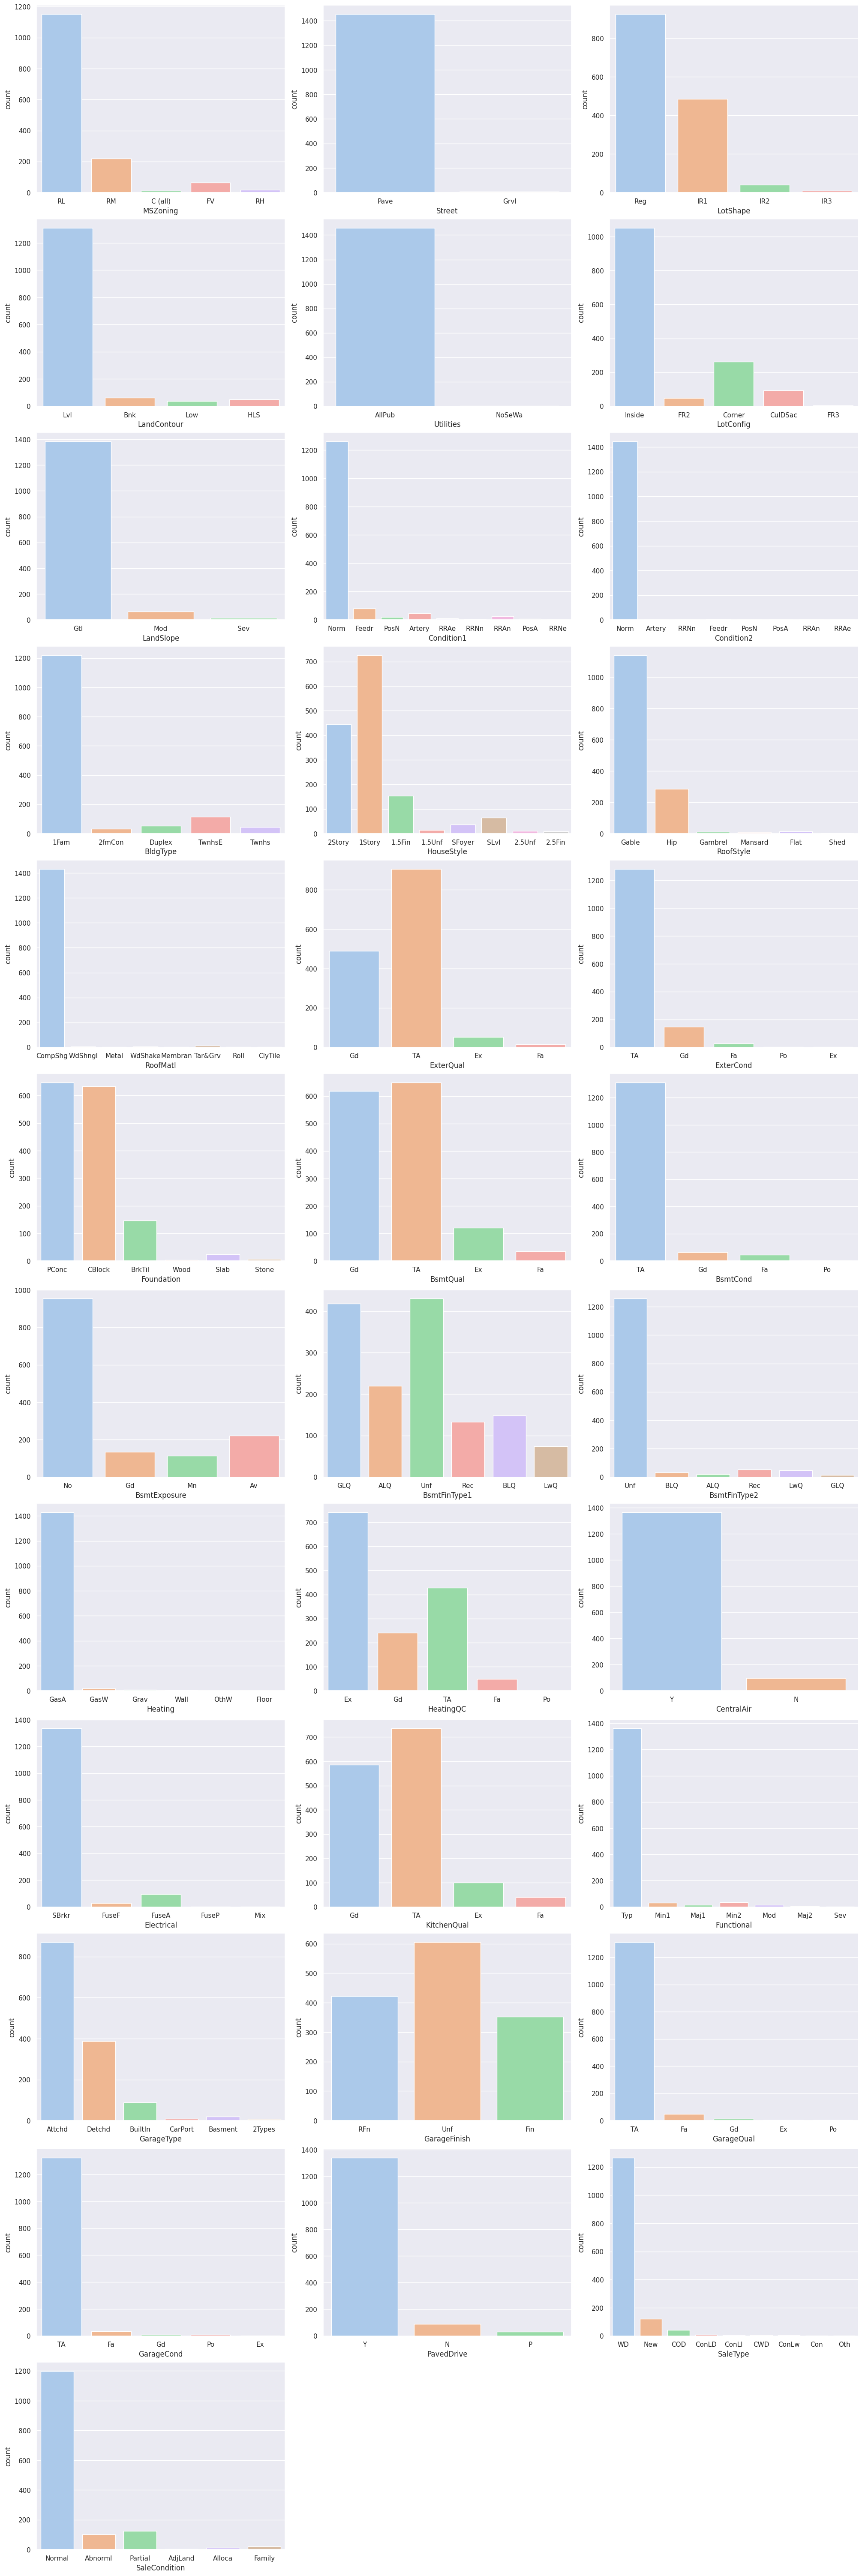

In [10]:
# Selecting categorical features
cat_features = data.select_dtypes(include=['object']).columns.tolist()
cat_features = [col for col in cat_features if col not in ['Neighborhood', 'Exterior2nd', 'Exterior1st']]

n_cols = 3  # Fixed number of columns
n_rows = math.ceil(len(cat_features) / n_cols)

# Setting up subplots for categorical columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Loop through each categorical column and plot a boxplot
for i, col in enumerate(cat_features):
    sns.countplot(data=data, x=col, ax=axes[i], palette="pastel")
    axes[i].set_xlabel(col)

# Remove unused subplots (only applies when len(cat_features) is odd)
for j in range(len(cat_features), len(axes)):
    fig.delaxes(axes[j])

# Show the plots
plt.show()

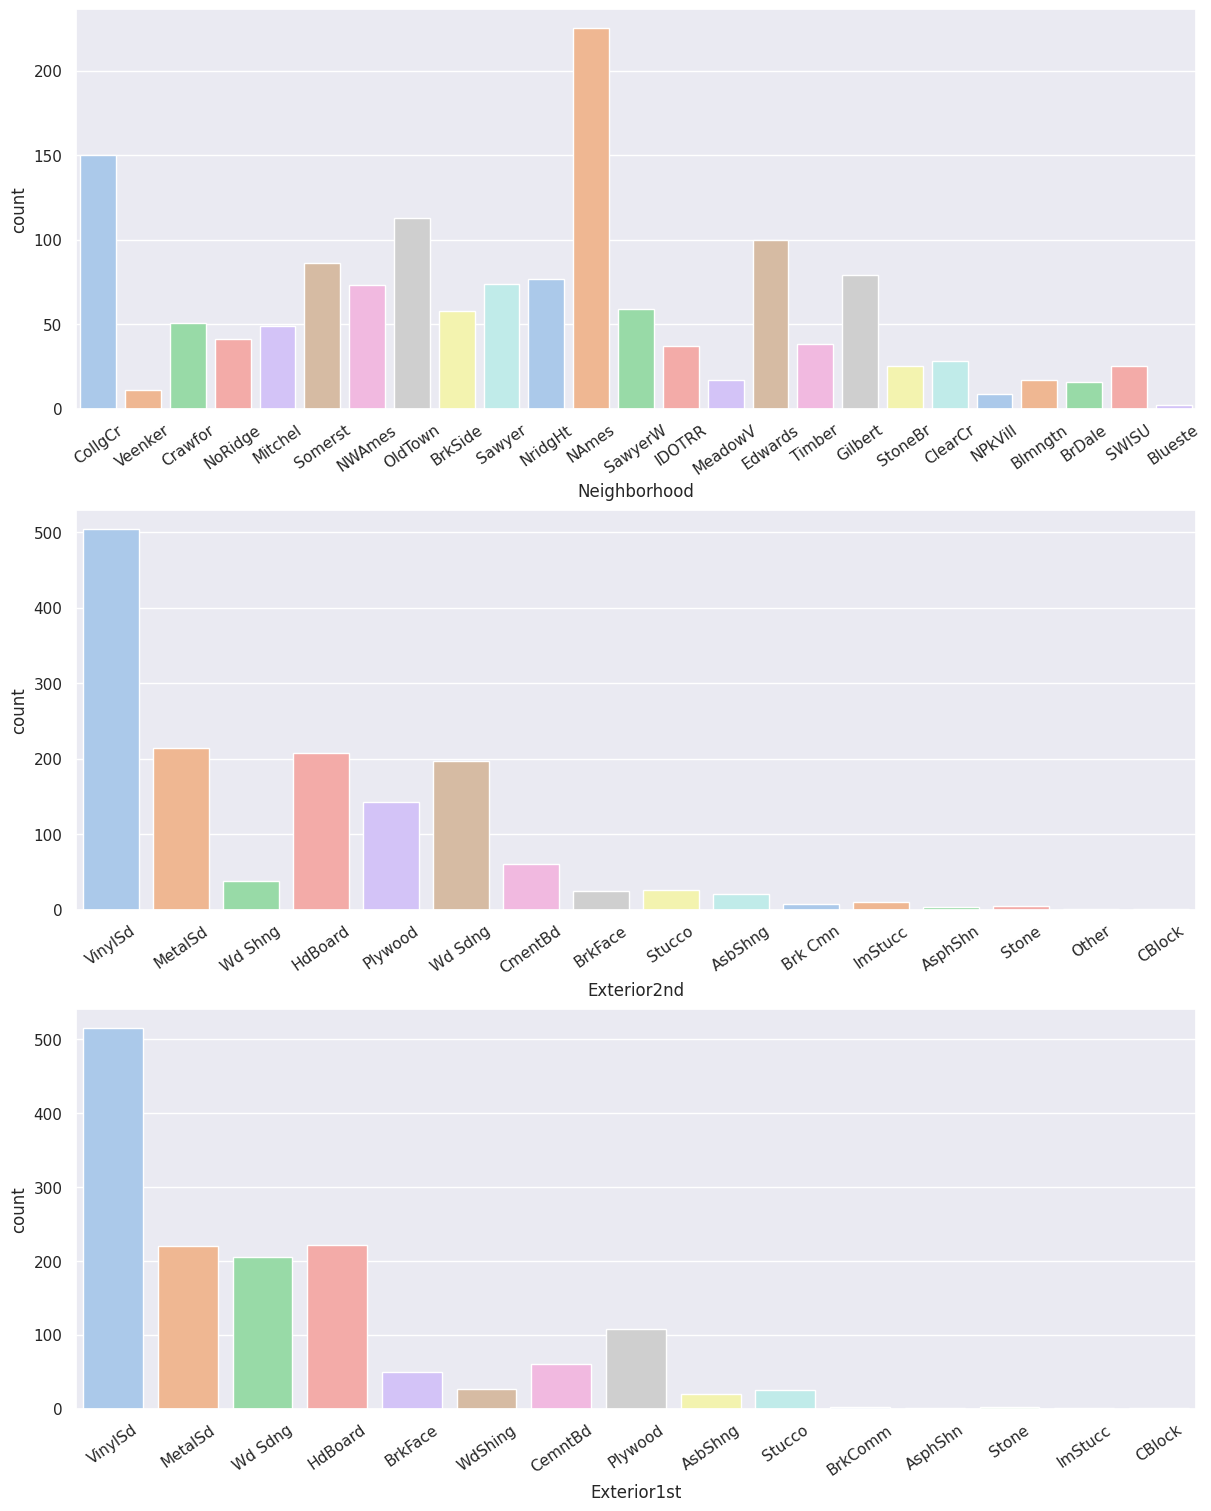

In [11]:
# List of features to plot separately
three_features = ['Neighborhood', 'Exterior2nd', 'Exterior1st']

# Setting up subplots for the three features
fig, axes = plt.subplots(len(three_features), 1, figsize=(12, 15), constrained_layout=True)

# Loop through each feature and create a countplot
for i, col in enumerate(three_features):
    sns.countplot(data=data, x=col, ax=axes[i], palette="pastel")
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=35)

# Show the plots
plt.show()

# Exploring Numrical Features

In [12]:
#show the Num of Unique Values of Num Feature
data.select_dtypes('number').nunique().sort_values()

BsmtHalfBath        3
HalfBath            3
FullBath            4
BsmtFullBath        4
Fireplaces          4
KitchenAbvGr        4
GarageCars          5
YrSold              5
BedroomAbvGr        8
PoolArea            8
OverallCond         9
OverallQual        10
TotRmsAbvGrd       12
MoSold             12
MSSubClass         15
3SsnPorch          20
MiscVal            21
LowQualFinSF       24
YearRemodAdd       61
ScreenPorch        76
GarageYrBlt        97
LotFrontage       110
YearBuilt         112
EnclosedPorch     120
BsmtFinSF2        144
OpenPorchSF       202
WoodDeckSF        274
MasVnrArea        327
2ndFlrSF          417
GarageArea        441
BsmtFinSF1        637
SalePrice         663
TotalBsmtSF       721
1stFlrSF          753
BsmtUnfSF         780
GrLivArea         861
LotArea          1073
Id               1460
dtype: int64

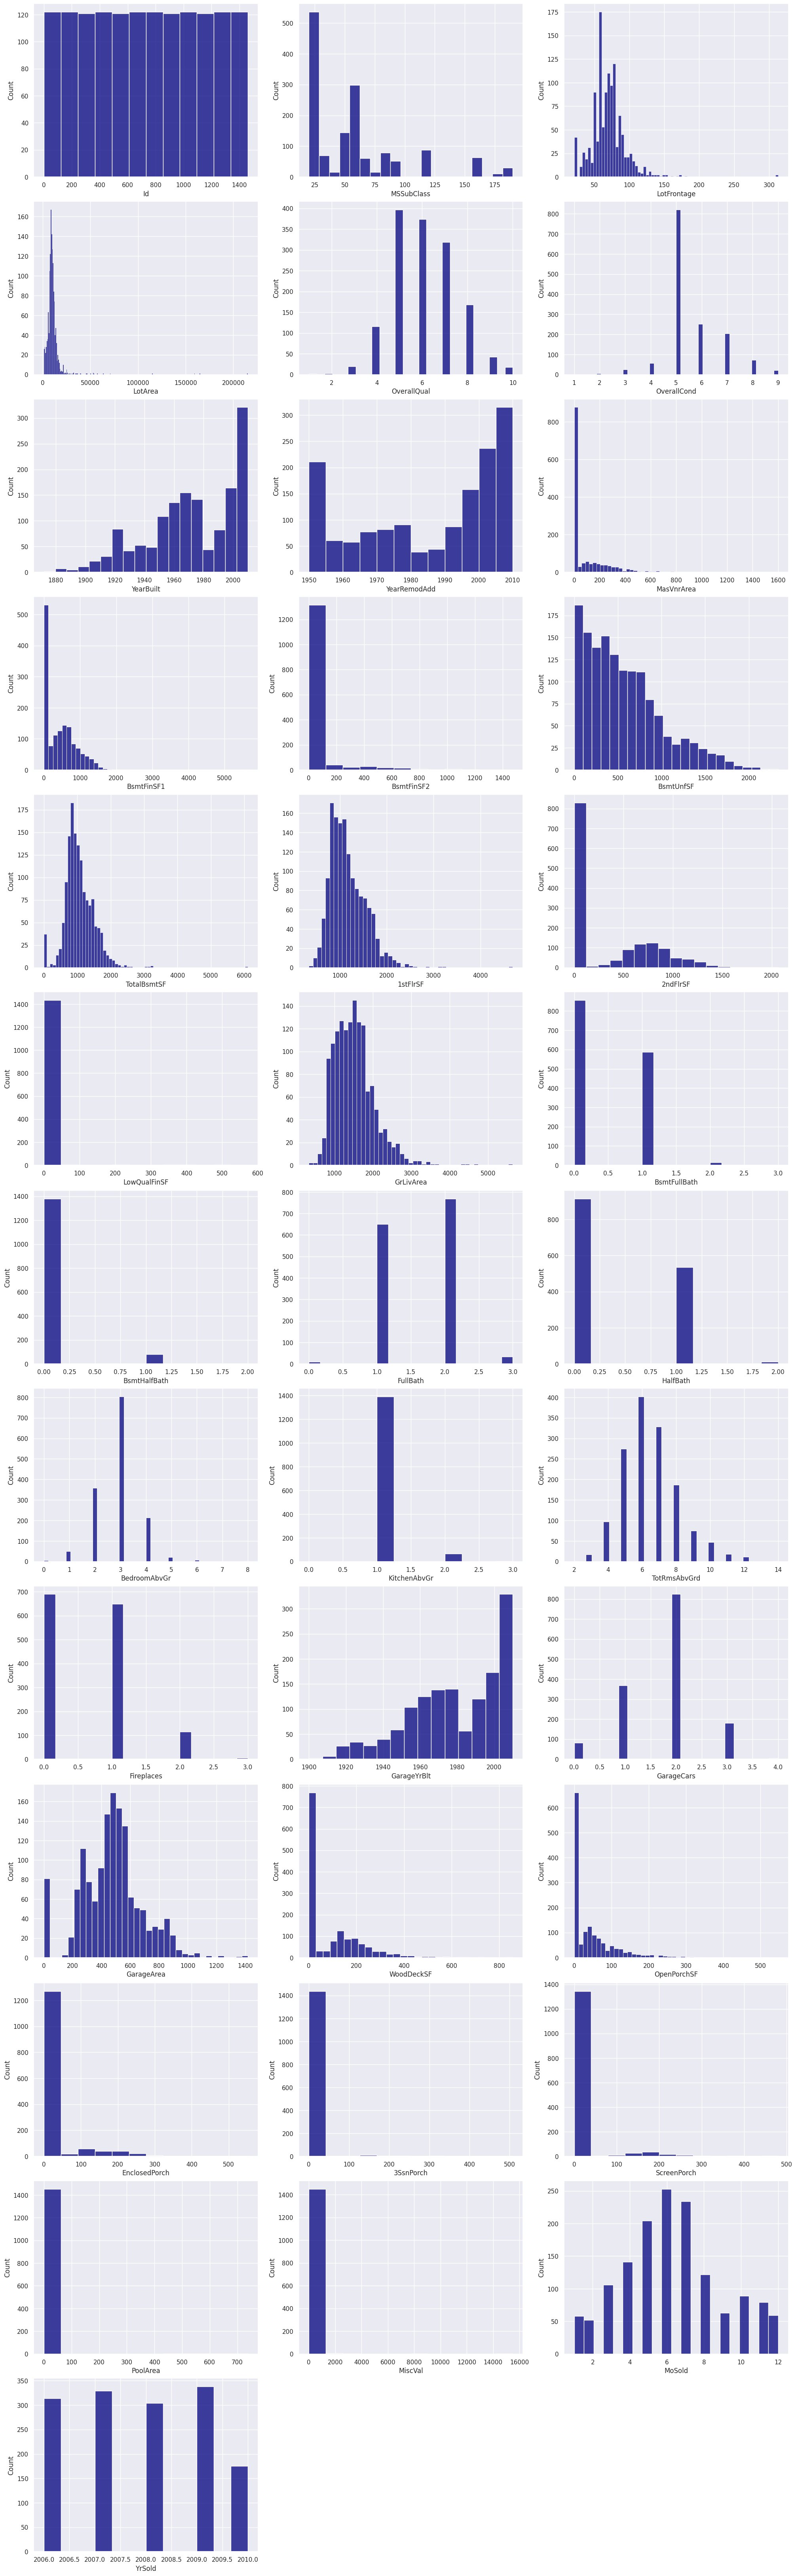

In [13]:
# Selecting Numerical features
num_features = data.select_dtypes(include=['number']).columns.tolist()
num_features = [col for col in num_features if col != "SalePrice"]

n_cols = 3  # Fixed number of columns
n_rows = math.ceil(len(num_features) / n_cols)

# Setting up subplots for Numerical columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Loop through each Numerical column and plot a histogram
for i, col in enumerate(num_features):
    sns.histplot(data=data , x=col, ax=axes[i] , color="navy")
    axes[i].set_xlabel(col)

# Remove unused subplots
for j in range(len(num_features), len(axes)):
    fig.delaxes(axes[j])

# Show the plots
plt.show()

# Target Distribition

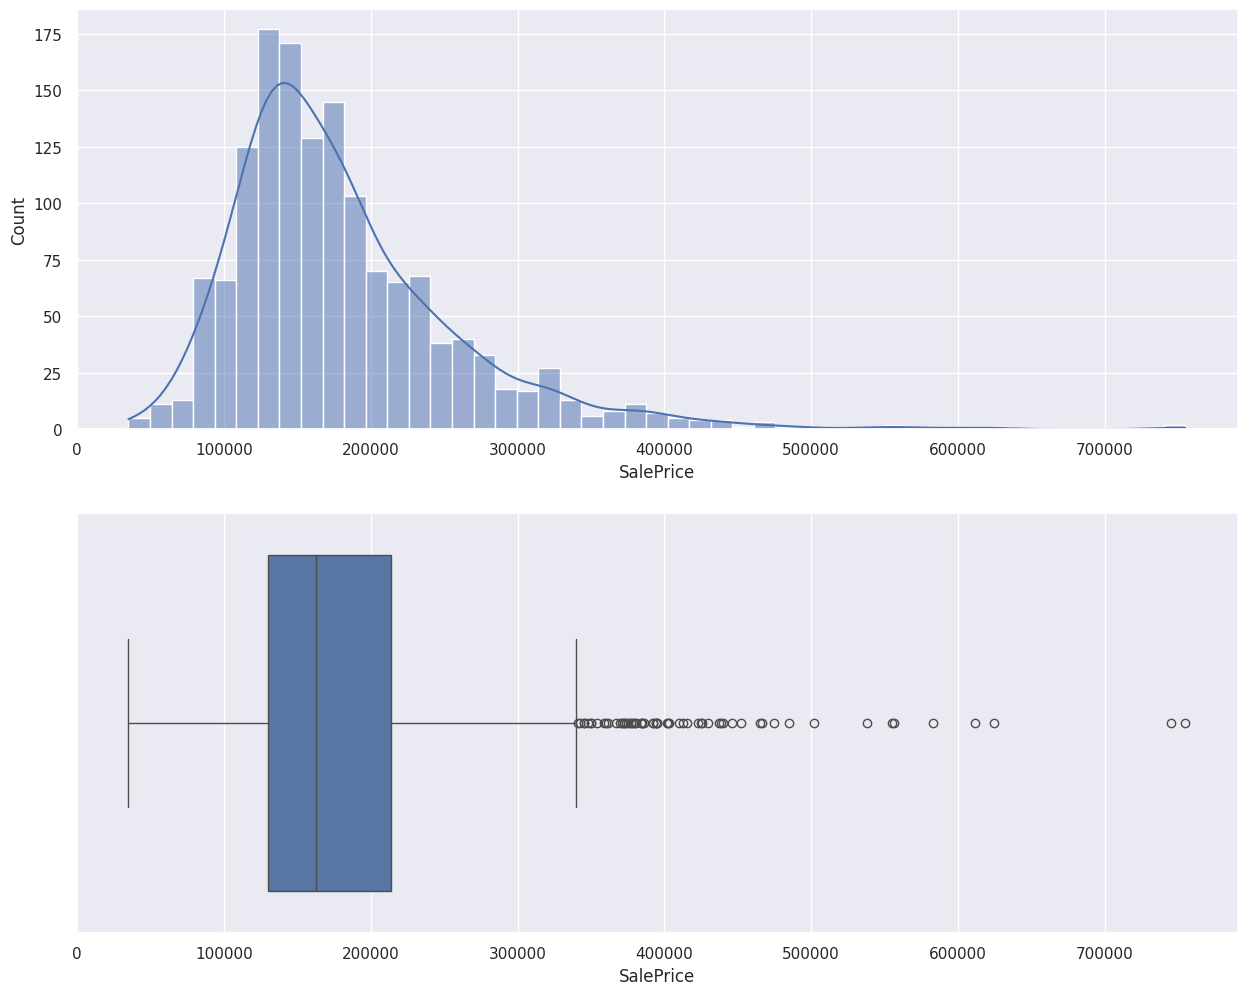

In [14]:
# Plot The Target
fig,ax = plt.subplots(2,1,figsize=(15,12))
sns.histplot(data['SalePrice'],ax=ax[0],kde=True)
sns.boxplot(data['SalePrice'],ax=ax[1],orient='h');

# Correlation

Cat Features Correlition

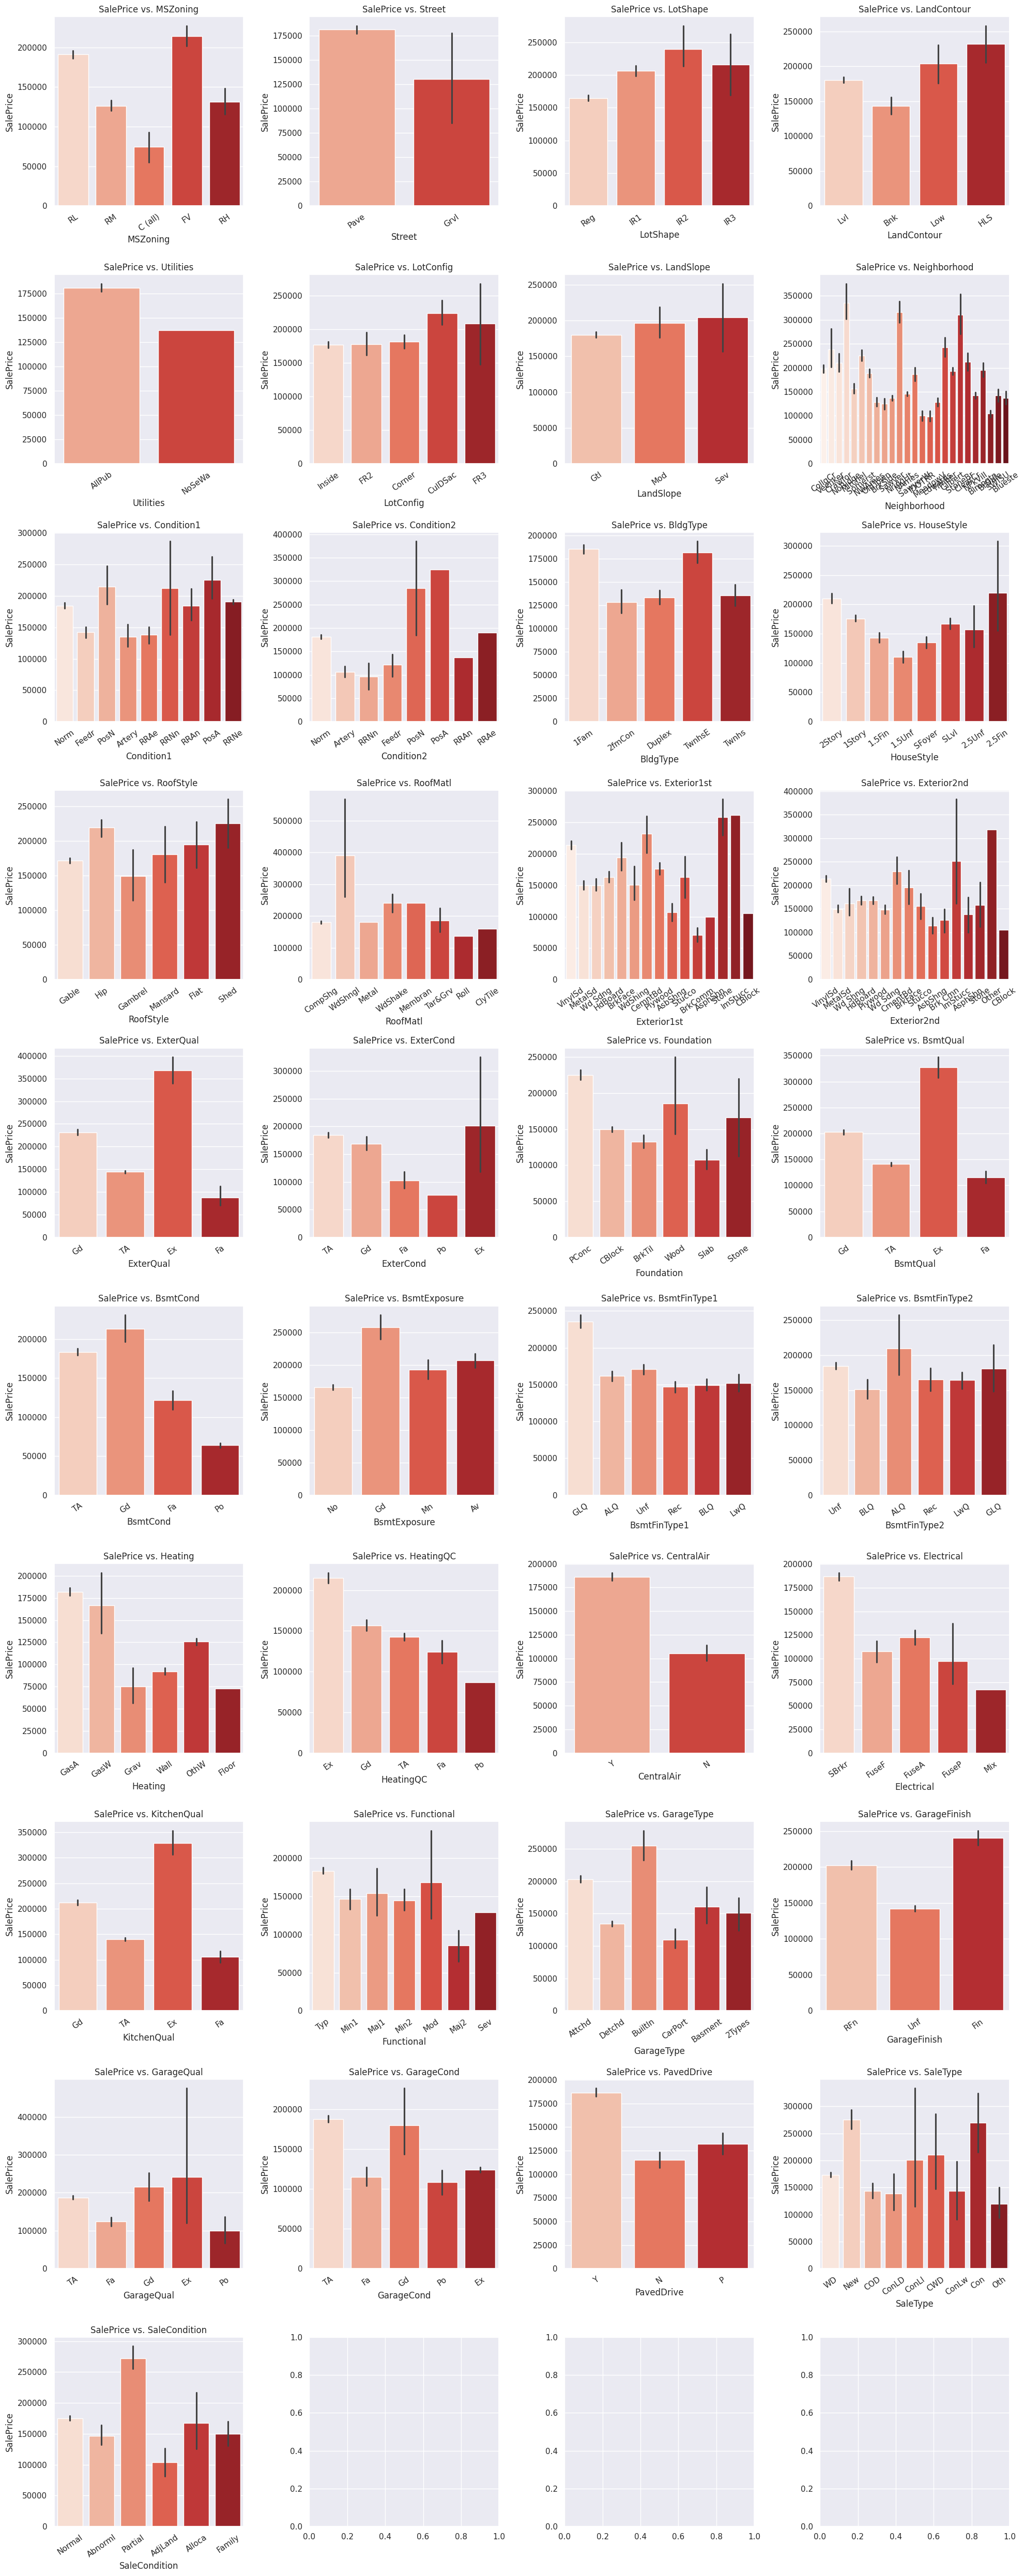

In [15]:
# Selecting categorical features
cat_features = data.select_dtypes(include=['object']).columns.tolist()

# Calculate number of rows & cols
n_cols = 4
n_rows = math.ceil(len(cat_features) / n_cols)

# Set up subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Plotting SalePrice vs. Categorical Features
for i, col in enumerate(cat_features):
    sns.barplot(data=data, x=col, y='SalePrice', palette="Reds", ax=axes[i])
    axes[i].set_title(f'SalePrice vs. {col}')
    axes[i].tick_params(axis='x', rotation=35)

plt.tight_layout()
plt.show()

Num Features Correlition

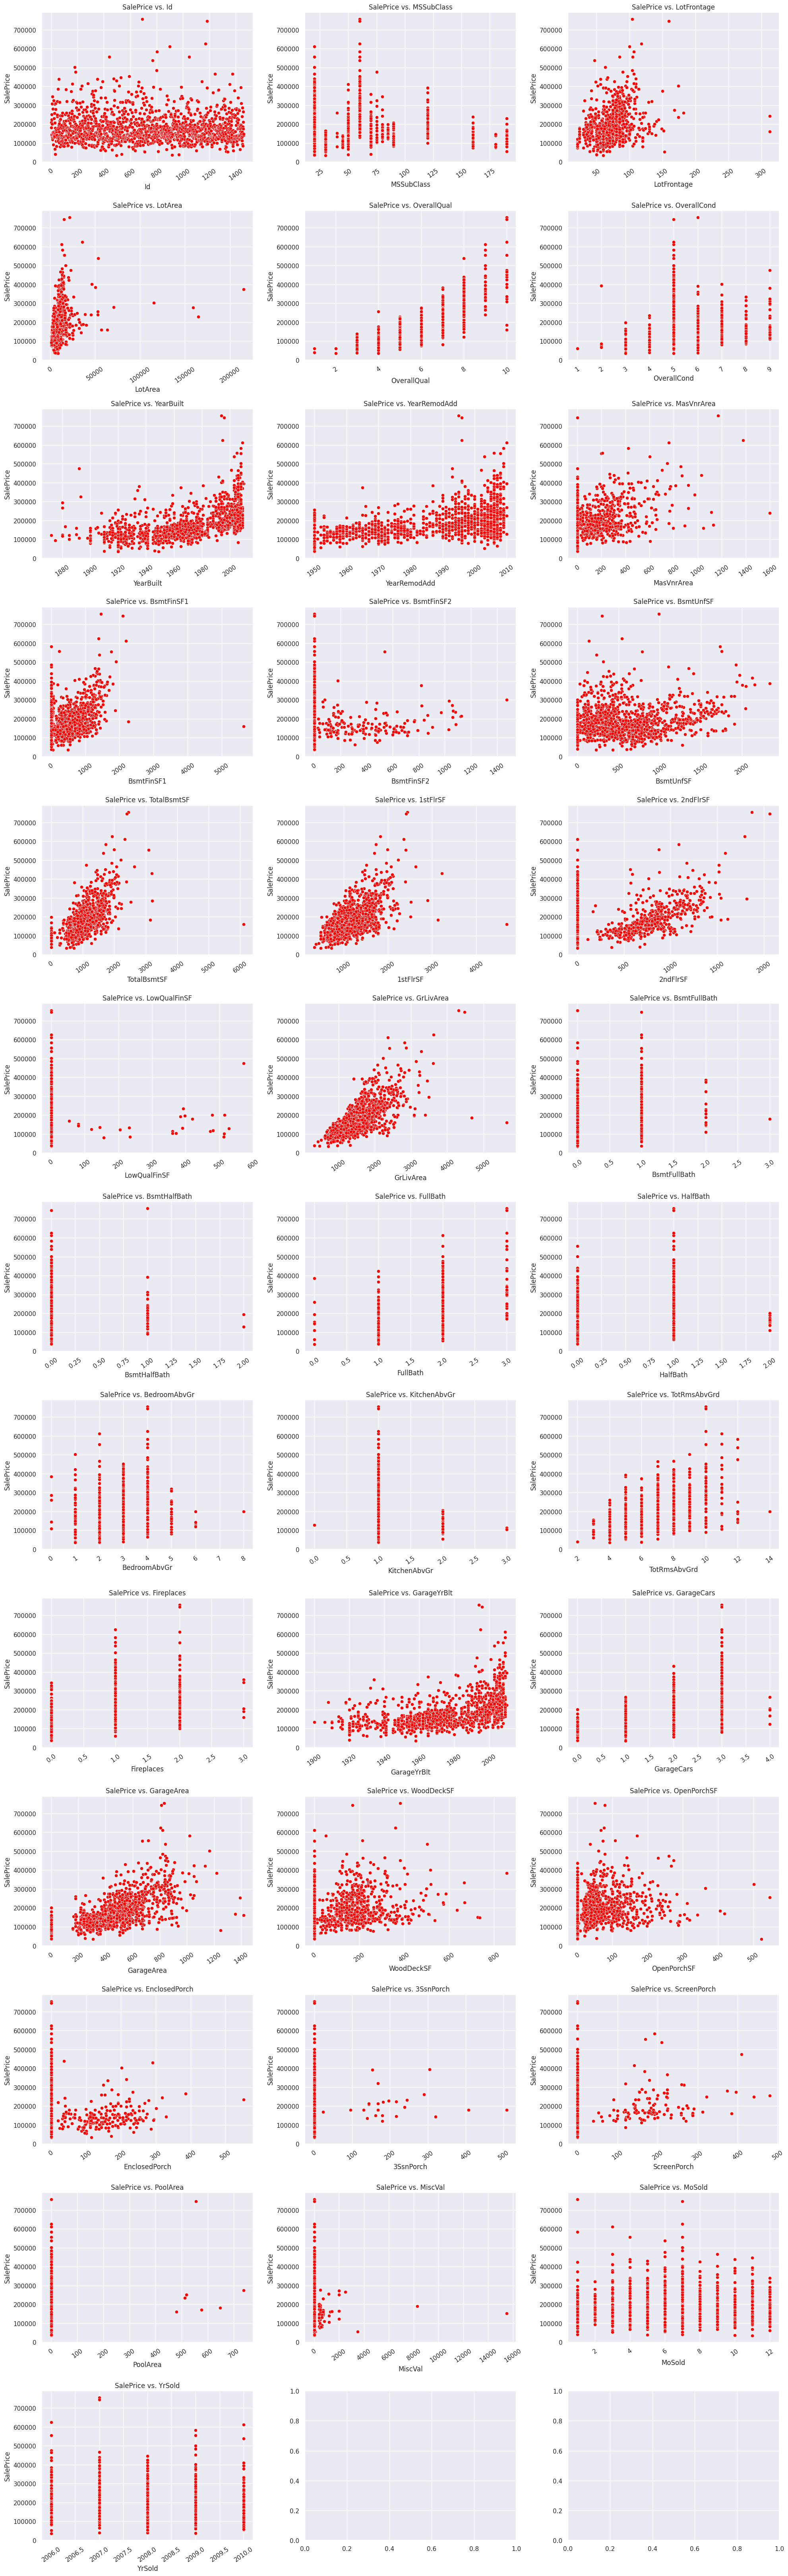

In [16]:
# Selecting numrical features
num_features = data.select_dtypes(include=['number']).columns.tolist()
num_features = [col for col in num_features if col != "SalePrice"]

# Calculate number of rows & cols
n_cols = 3
n_rows = math.ceil(len(num_features) / n_cols)

# Set up subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Plotting SalePrice vs. numrical Features
for i, col in enumerate(num_features):
    sns.scatterplot(data=data, x=col, y='SalePrice', color="red", ax=axes[i])
    axes[i].set_title(f'SalePrice vs. {col}')
    axes[i].tick_params(axis='x', rotation=35)

plt.tight_layout()
plt.show()

In [17]:
# Correlition with The Nums Features
corr = data.select_dtypes("number").corr()['SalePrice'].sort_values(ascending=False).abs()
corr

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2       0.011378
BsmtHalfBath     0.016844
MiscVal          0.021190
Id               0.021917
LowQualFinSF     0.025606
YrSold           0.028923
OverallCond      0.077856
MSSubClass       0.084284
EnclosedPorch    0.128578
KitchenAbvGr     0.135907
Name: SalePrice, dtype: float64

In [18]:
# Drop columns with correlation less than 0.2
data.drop(columns=corr[corr < 0.3].index, inplace=True, axis=1)

In [19]:
# Check The Shape after drop the unnessecry features
data.shape

(1460, 56)

# Elbow Method

* This method is used to determine the best number of components to include in PCA.

In [20]:
#split the data for pca
x = data.select_dtypes("number").drop(columns=['SalePrice'])

xtrain , xtest = train_test_split(x ,test_size=0.2 , random_state=42)

xtrain.shape , xtest.shape

((1168, 18), (292, 18))

In [21]:
#make PCA with all Features
full_pca = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    PCA(n_components=xtrain.shape[1]))


xtrain_pca = full_pca.fit_transform(xtrain)

In [22]:
#check the num of features
full_pca.named_steps['pca'].n_components_

18

In [23]:
# Plot the cumulative explained variance ratio of PCA components
px.area(x=range(1, 19), y=full_pca.named_steps['pca'].explained_variance_ratio_.cumsum(),
        labels={'x': 'Principal Component', 'y': 'Cumulative Explained Variance'},
        title='Explained Variance Ratio for Each Principal Component')

# Data Spliting & Preprocessing

In [24]:
#split the data
x = data.drop(columns=['SalePrice'])
y = data['SalePrice']

# Define the numerical and categorical features
num_features = x.select_dtypes("number").columns.tolist()
cat_features = x.select_dtypes("object").columns.tolist()

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [25]:
#Make a Num Pipeline
num_pipeline = make_pipeline(
                SimpleImputer(strategy='median'),
                StandardScaler(),
                PCA(n_components=0.9))

#Make a Cat Pipeline
cat_pipeline = make_pipeline(
                SimpleImputer(strategy='most_frequent'),
                BinaryEncoder())

preprocessor = make_column_transformer(
                    (num_pipeline, num_features),
                    (cat_pipeline, cat_features))

# Modeling

We Need to declare 2 Functions
1. Model Tunning
2. Model Evaluation

In [26]:
def model_tuning(model, x, y, params):
    '''
    Parameters:
        1. model: the model we want to tune.
        2. x: feature matrix.
        3. y: target vector.
        4. params: hyperparameters we want to tune.

    Returns:
        best model: the model with the best hyperparameters after tuning.
    '''

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,
        scoring='r2')

    grid_search.fit(x, y)  # fit the model to the data
    print(f"Best parameters: {grid_search.best_params_}")  # print the best hyperparameters
    print(f"Best score (R^2): {grid_search.best_score_:.2f}")  # print the best R^2 score

    return grid_search.best_estimator_


In [30]:
def model_evaluation(model, x, y, n):

    '''This function validates the model across multiple stratified splits using cross-validation'''

    # Perform cross-validation
    scores = cross_val_score(model, x, y, scoring='r2', cv=n)

    # Calculate the mean score and standard deviation across all folds
    print(f'R^2 Score (mean): {scores.mean():.2f}')
    print(f'R^2 Score (std): {scores.std():.2f}')

    # Calculate accuracy
    print("Accuracy: ",model.score(x,y))

    # Make predictions to calculate RMSE
    y_pred = model.predict(x)

    # Calculate and print RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f'RMSE: {rmse:.2f}')

# 1.Linear Regression

In [28]:
#Define The lInear Model and PolynomialFeatures
lin_reg = make_pipeline(preprocessor,
                        PolynomialFeatures(degree=2),
                        LinearRegression())

# Paramaters for lin model
params = {'polynomialfeatures__degree':[1,2,3]}

# Tuning
best_lin = model_tuning(lin_reg, xtrain, ytrain, params)
best_lin

Best parameters: {'polynomialfeatures__degree': 3}
Best score (R^2): -7.30


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.9))]),
                                                  ['LotFrontage', 'OverallQual',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'GrLivArea',
                                                   'F...
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', ...])])),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [31]:
# Evaluation the Model
model_evaluation(best_lin,xtrain, ytrain,5)

R^2 Score (mean): -7.30
R^2 Score (std): 10.96
Accuracy:  1.0
RMSE: 0.00


# 2.Ridge

In [32]:
#Define The Ridge Model and PolynomialFeatures
ridge = make_pipeline(preprocessor,
                      PolynomialFeatures(degree=2),
                      Ridge())

# Paramaters for Ridge model
params = {'polynomialfeatures__degree':[1,2,3],
          'ridge__alpha':[0.01,0.1,1,10,100]}

# Tuning
best_ridge = model_tuning(ridge, xtrain, ytrain, params)
best_ridge

Best parameters: {'polynomialfeatures__degree': 1, 'ridge__alpha': 10}
Best score (R^2): 0.81


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.9))]),
                                                  ['LotFrontage', 'OverallQual',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'GrLivArea',
                                                   'F...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', ...])])),
                ('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('ridge', Ridge(alpha=10))])

In [66]:
# Evaluation the Model
model_evaluation(best_ridge,xtrain, ytrain,5)

R^2 Score (mean): 0.81
R^2 Score (std): 0.07
Accuracy:  0.8615641298316676
RMSE: 28735.13


# 3.Lasso

In [70]:
#Define The Lasso Model and PolynomialFeatures
#lasso = make_pipeline(preprocessor,
#                     PolynomialFeatures(degree=2),
#                    Lasso())

# Paramaters for Lasso model
#params = {'polynomialfeatures__degree':[1,2,3],
#          'lasso__alpha':[0.01,0.1,1,10,100]}

# Tuning
#best_lasso = model_tuning(lasso, xtrain, ytrain, params)
#best_lasso

In [71]:
# Evaluation the Model
#model_evaluation(best_lasso,xtrain, ytrain,5)

# 4.SVR

In [39]:
#Define The SVR Model with Poly kernel
svr = make_pipeline(
    preprocessor,
    SVR(kernel='poly')
)

# Paramaters for svr model
params = {
    'svr__C':[1000, 10000, 100000],
    'svr__degree':[2,3,4],
    'svr__epsilon':[0.0001,0.00001,0.000001],
}

# Tunning
best_svr = model_tuning(svr,xtrain,ytrain,params)
best_svr

Best parameters: {'svr__C': 10000, 'svr__degree': 2, 'svr__epsilon': 1e-06}
Best score (R^2): 0.78


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.9))]),
                                                  ['LotFrontage', 'OverallQual',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'GrLivArea',
                                                   'F...
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', ...])])),
                ('svr', SVR(C=10000, degree=2, epsilon=1e-06, kernel='poly'))])

In [40]:
# Evaluation the Model
model_evaluation(best_svr,xtrain, ytrain,5)

R^2 Score (mean): 0.78
R^2 Score (std): 0.16
Accuracy:  0.8977856752321515
RMSE: 24691.34


# 5.KNNRegressor

In [41]:
#Define The KNN Model
knn = make_pipeline(
    preprocessor,
    KNeighborsRegressor())

# Parameters for  KNN Regressor
params = {
    'kneighborsregressor__n_neighbors': list(range(1, 16)),
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__metric': ['minkowski', 'euclidean', 'manhattan']
}

# Tune the model
best_knn = model_tuning(knn, xtrain, ytrain, params)
best_knn

Best parameters: {'kneighborsregressor__metric': 'minkowski', 'kneighborsregressor__n_neighbors': 14, 'kneighborsregressor__weights': 'distance'}
Best score (R^2): 0.80


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.9))]),
                                                  ['LotFrontage', 'OverallQual',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'GrLivArea',
                                                   'F...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', ...])])),
                ('kneighborsregressor',
                 KNeighborsRegressor(n_neighbors=14, weights='distance'))])

In [42]:
# Evaluation the Model
model_evaluation(best_knn,xtrain, ytrain,5)

R^2 Score (mean): 0.80
R^2 Score (std): 0.04
Accuracy:  0.9999999999999807
RMSE: 0.01


# 6.Decision Tree Regressor

In [43]:
#Define The Decision Tree Regressor Model
tree = make_pipeline(
    preprocessor,
    DecisionTreeRegressor())

# Parameters for Tree Regressor
params = {
    'decisiontreeregressor__max_depth': [None] + list(range(1, 20)),
    'decisiontreeregressor__min_samples_split': [2, 5, 10],
    'decisiontreeregressor__min_samples_leaf': [1, 2, 4]
}

# Tune the model
best_tree = model_tuning(tree, xtrain, ytrain, params)
best_tree

Best parameters: {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 2}
Best score (R^2): 0.78


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.9))]),
                                                  ['LotFrontage', 'OverallQual',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'GrLivArea',
                                                   'F...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', ...])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=4))])

In [44]:
# Evaluation the Model
model_evaluation(best_tree,xtrain, ytrain,5)

R^2 Score (mean): 0.79
R^2 Score (std): 0.05
Accuracy:  0.8933906988741027
RMSE: 25216.59


# 7.Random Forest Regressor

In [45]:
#Define The Random Forest Regressor Model
forest = make_pipeline(
    preprocessor,
    RandomForestRegressor())

# Parameters for forest Regressor
params = {
    'randomforestregressor__n_estimators': [25,50,75,100],
    'randomforestregressor__max_depth': [None] + list(range(1, 20)),
    'randomforestregressor__min_samples_split': [2, 5, 10]
}

# Tune the model
best_forest = model_tuning(forest, xtrain, ytrain, params)
best_forest

Best parameters: {'randomforestregressor__max_depth': 17, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 25}
Best score (R^2): 0.85


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.9))]),
                                                  ['LotFrontage', 'OverallQual',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'GrLivArea',
                                                   'F...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', ...])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=17, n_estimators=25))])

In [46]:
# Evaluation the Model
model_evaluation(best_forest,xtrain, ytrain,5)

R^2 Score (mean): 0.83
R^2 Score (std): 0.04
Accuracy:  0.9770075376070836
RMSE: 11710.67


# 8.Voting Regressor

In [58]:
# Create Voting Regressor
voting = VotingRegressor(
            estimators=[
                ('svr', best_svr),
                ('knn', best_knn),
                ('dt', best_tree)])

# Fitting The model
voting = voting.fit(xtrain, ytrain)

# Evaluation the Model
model_evaluation(voting,xtrain, ytrain,5)

R^2 Score (mean): 0.83
R^2 Score (std): 0.07
Accuracy:  0.9614475174719928
RMSE: 15164.04


# 9.XGB Regressor

In [59]:
# Initialize the XGBoost Regressor
xgb = make_pipeline(
    preprocessor,
    XGBRegressor(random_state=42))

# Parameters for xgb Regressor
params = {
    'xgbregressor__n_estimators': [25,50,75,100],
    'xgbregressor__max_depth': [5,7,9,11],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2]}

# Tune the model
best_xgb = model_tuning(xgb, xtrain, ytrain, params)
best_xgb

Best parameters: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 7, 'xgbregressor__n_estimators': 100}
Best score (R^2): 0.85


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.9))]),
                                                  ['LotFrontage', 'OverallQual',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'GrLivArea',
                                                   'F...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [60]:
# Evaluation the Model
model_evaluation(best_xgb,xtrain, ytrain,5)

R^2 Score (mean): 0.85
R^2 Score (std): 0.03
Accuracy:  0.9984076023101807
RMSE: 3081.90


# Testing

Evaluate the best-performing models on the test set
* KNN 99% Training
* Random Forest 97% Training
* Voting 96% Training
* XGB 99% Training

In [62]:
# Evaluation the knn Model on testing
model_evaluation(best_knn,xtest, ytest,5)

R^2 Score (mean): 0.75
R^2 Score (std): 0.07
Accuracy:  0.835627685625435
RMSE: 35507.59


In [63]:
# Evaluation the forest Model on testing
model_evaluation(best_forest,xtest, ytest,5)

R^2 Score (mean): 0.83
R^2 Score (std): 0.04
Accuracy:  0.8830279691271512
RMSE: 29953.52


In [64]:
# Evaluation the voting Model on testing
model_evaluation(voting,xtest, ytest,5)

R^2 Score (mean): 0.83
R^2 Score (std): 0.03
Accuracy:  0.8696660829765643
RMSE: 31618.09


In [65]:
# Evaluation the xgb Model on testing
model_evaluation(best_xgb,xtest, ytest,5)

R^2 Score (mean): 0.83
R^2 Score (std): 0.04
Accuracy:  0.8964167833328247
RMSE: 28187.18


# Conclusion
 **We used PCA with n_components=0.9 for dimensionality reduction.**
**After trying multiple models, the best performance was observed with the following models:**
* KNN 83% Testing Accuracy
* Random Forest 88% Testing Accuracy
* Voting Regressor 86% Testing Accuracy
* **XGBoost** is The best model We Got , which achieved:
99% Training Accuracy
89% Testing Accuracy